## Variable importance

Calculate, plot and compare variable importance for models v1 and v2, agaist pearson´s R2 coeff.

In [30]:
# Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
import os

from tensorflow.keras.models import load_model

from sklearn.inspection import permutation_importance

from matplotlib.colors import CenteredNorm, LinearSegmentedColormap

sys.path.append("../..")

from src.processing import windsat_datacube, model_preprocess, \
    telsem_datacube, doy2month_mapping

from src.model import xy_split


# Files
ws_path = "../../data/raw/daily_windsat/"
telsem_folder = r"..\..\data\processed\WindsatEmiss"


In [31]:
# Define / load the models

regressions = { # Swath : (a,b)
    0 : (0.56, 138.29),
    1 : (0.54 , 142.98)
}

model_folder = "..\..\models"

modelsv1 = {
    0 : load_model(os.path.join(model_folder, "WSMv1_A_2024_07_23T135732" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv1_D_2024_07_23T120006" + ".keras")),
}

modelsv2 = {
    0 : load_model(os.path.join(model_folder, "WSMv2_A_2024_07_23T202640" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv2_D_2024_07_23T180208" + ".keras")),
}

In [32]:
# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")

In [33]:
# Preprocessing of windsat datacube
ws_ds = windsat_datacube(ws_path)
swath = 0 

In [34]:
# Load the combined dataframe

swath_ds= model_preprocess(ws_ds, swath_sector=swath, look="impute", add_look_flag=False)
swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

day_mapping = doy2month_mapping()
swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")

# Inner join the telsem df and the ascending df
df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
df = df.drop(columns="month")

# Save the original lat lon for plotting later
lat = df["lat"].copy()
lon = df["lon"].copy()

df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

# Model v2 predictions

model = modelsv2[swath]

# Predict for the local sample:
X, y = xy_split(df, y_column = "surtep_ERA5")
df["surtep_MODEL"] = model.predict(X)
df["v2_error"] = df["surtep_MODEL"] - df["surtep_ERA5"] 

# Re add lon and lat as they were
df["lat"] = lat
df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
v2error_df = df[["lat","lon","v2_error"]]
v2error_df.set_index(keys=["lat","lon"], inplace=True)
v2error_df = v2error_df.groupby(by=["lat","lon"]).mean()
v2error_df.reset_index(inplace=True)

print("Variable importances")
var_importances = permutation_importance(
model, X, y,
scoring="neg_median_absolute_error",
max_samples= 0.1, # We have a lot of data, use only 10 % 
n_repeats=3
)

# Get te results into a readable table:
importance = var_importances.importances_mean
importances ={var:value for var,value in zip(X.columns, importance)}

# dataframe format
importancesv2_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
importancesv2_df["importance"] = importancesv2_df["importance [mse]"] / importancesv2_df["importance [mse]"].sum()


52364/52364 ━━━━━━━━━━━━━━━━━━━━ 46s 872us/step
Variable importances
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 37s 712us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 698us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 850us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 736us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 678us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 710us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 900us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 790us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 805us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 784us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 891us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 744us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 820us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 706us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 678us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 739us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 739us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 737us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 3s 657us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━

In [35]:
# Pearson's R2 coeff
r2_values_list = []
for column in X.columns:
    # Compute the Pearson correlation coefficient between the feature and y
    r = np.corrcoef(X[column], y)[0, 1]
    # Square the correlation coefficient to get R^2
    r2 = r**2
    # Append the result to the DataFrame
    r2_values_list.append({'Feature': column, 'R^2': r2})

r2_values = pd.DataFrame(r2_values_list)


In [36]:
# Select the variables for model v1 and calculate the mse

lat = df["lat"].copy()
lon = df["lon"].copy()

df["lon"] = df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
df["lat"] = df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

model = modelsv1[swath]

df = df[
    [
        'surtep_ERA5',
        'lat',
        'lon',
        'tbtoa_18Ghz_V',
        'tbtoa_18Ghz_H',
        'tbtoa_37Ghz_V',
        'tbtoa_37Ghz_H'
    ]
]

# Predict for the local sample:
X, y = xy_split(df, y_column = "surtep_ERA5")
df["surtep_MODEL"] = model.predict(X)
df["v1_error"] = df["surtep_MODEL"] - df["surtep_ERA5"] 

# Re add lon and lat as they were
df["lat"] = lat
df["lon"] = lon

# Calculate the error per pixel, group by lat and lon
v1error_df = df[["lat","lon","v1_error"]]
v1error_df.set_index(keys=["lat","lon"], inplace=True)
v1error_df = v2error_df.groupby(by=["lat","lon"]).mean()
v1error_df.reset_index(inplace=True)

print("Variable importances")
var_importances = permutation_importance(
model, X, y,
scoring="neg_median_absolute_error",
max_samples= 0.1, # We have a lot of data, use only 10 % 
n_repeats=3
)

# Get te results into a readable table:
importance = var_importances.importances_mean
importances ={var:value for var,value in zip(X.columns, importance)}


# dataframe format
importancesv1_df = pd.DataFrame.from_dict(importances, orient="index", columns=["importance [mse]"])
importancesv1_df["importance"] = importancesv1_df["importance [mse]"] / importancesv1_df["importance [mse]"].sum()

52364/52364 ━━━━━━━━━━━━━━━━━━━━ 42s 792us/step
Variable importances
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 42s 800us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 929us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 924us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 933us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 818us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 981us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 904us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 5s 861us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 723us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 703us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 724us/step
5237/5237 ━━━━━━━━━━━━━━━━━━━━ 4s 701us/step


In [37]:
r2_values

,Feature,R^2
0,lat,0.116907
1,lon,0.004545
2,tbtoa_18Ghz_V,0.504210
3,tbtoa_18Ghz_H,0.154947
4,tbtoa_37Ghz_V,0.551042
5,tbtoa_37Ghz_H,0.201923
6,Emis19V,0.019133
7,Emis19H,0.000470
8,Emis37V,0.010073
9,Emis37H,0.000118


In [38]:
importancesv1_df

,importance [mse],importance
lat,1.206940,0.046829
lon,0.179703,0.006972
tbtoa_18Ghz_V,6.352183,0.246465
tbtoa_18Ghz_H,3.353663,0.130122
tbtoa_37Ghz_V,11.393158,0.442056
tbtoa_37Ghz_H,3.287491,0.127555


In [39]:
importancesv2_df

,importance [mse],importance
lat,0.770386,0.031452
lon,0.077993,0.003184
tbtoa_18Ghz_V,7.713760,0.314925
tbtoa_18Ghz_H,3.114558,0.127156
tbtoa_37Ghz_V,6.084330,0.248401
tbtoa_37Ghz_H,3.318573,0.135485
Emis19V,0.728048,0.029724
Emis19H,0.556305,0.022712
Emis37V,0.919184,0.037527
Emis37H,1.210800,0.049433


In [50]:
# Combine the dataframes 



results_df = r2_values.merge(importancesv1_df.reset_index(names="Feature"), how = "outer", on="Feature")
results_df = results_df.merge(importancesv2_df.reset_index(names="Feature"), how = "outer", on="Feature", suffixes=("_v1","_v2"))
results_df = results_df[::-1]
results_df

,Feature,R^2,importance [mse]_v1,importance_v1,importance [mse]_v2,importance_v2
9,tbtoa_37Ghz_V,0.551042,11.393158,0.442056,6.084330,0.248401
8,tbtoa_37Ghz_H,0.201923,3.287491,0.127555,3.318573,0.135485
7,tbtoa_18Ghz_V,0.504210,6.352183,0.246465,7.713760,0.314925
6,tbtoa_18Ghz_H,0.154947,3.353663,0.130122,3.114558,0.127156
5,lon,0.004545,0.179703,0.006972,0.077993,0.003184
4,lat,0.116907,1.206940,0.046829,0.770386,0.031452
3,Emis37V,0.010073,NaN,NaN,0.919184,0.037527
2,Emis37H,0.000118,NaN,NaN,1.210800,0.049433
1,Emis19V,0.019133,NaN,NaN,0.728048,0.029724
0,Emis19H,0.000470,NaN,NaN,0.556305,0.022712


<Axes: xlabel='Feature'>

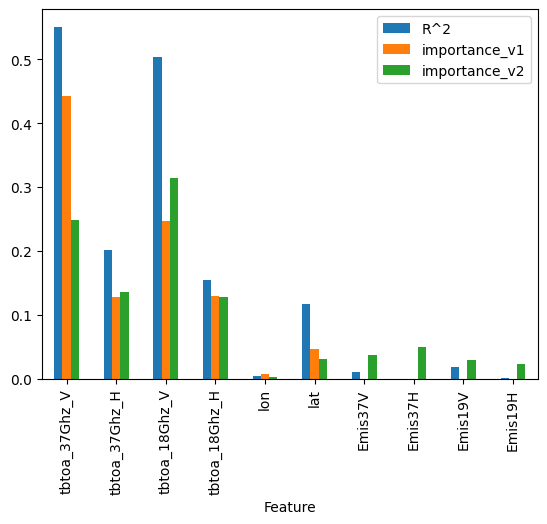

In [56]:
to_plot = results_df[[
    "Feature",
    "R^2",
    "importance_v1",
    "importance_v2"
]]

ax = to_plot.plot.bar(x = "Feature")